Loading important libraries and initial setup:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [4]:
# !pip install torch torchvision torchaudio

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Downloading data from torchvision datasets:

In [6]:
# setting transform pipeline:
transform = transforms.Compose(
    [
        transforms.ToTensor(), # converting images to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [8]:
# downloading training data:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', # saving data in the 'data' directory
    train=True, # training data
    download=True,
    transform = transform
)

# downloading testing data:
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print('Data downloaded successfully!')

Data downloaded successfully!


### Creating DataLoaders to handle batching and shuffling:

In [23]:
# Defining hyperparameters:
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

In [10]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f'Train loader size: {len(train_loader)} batches')
print(f'Test loader size: {len(test_loader)} batches')

Train loader size: 782 batches
Test loader size: 157 batches


In [11]:
# Defining target classes:
classes=('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')     # got these classes from the CIFAR10 dataset documentation

## Defining CNN Model:

In [25]:
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super(CIFAR_CNN, self).__init__()
        
        # First convolutional layer - input = 3*32*32
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1),    # use formulae: padding = kernel//2 and output = [{(input-kernel+2Padding)/Stride} + 1] to get an idea of stride and padding values.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)    # reduces the image size from 32x32 to 16x16
        )
        
        # Second convolutional layer - input = 6*16*16
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)    # reduces the image size from 16x16 to 8x8
        )
        
        # Third convolutional layer - input = 12*8*8
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)    # reduces the image size from 8x8 to 4x4
        )
        
        # Fully connected layer - input = 24*4*4
        self.fct1 = nn.Sequential(
            nn.Linear(in_features=24*4*4, out_features=500), 
            nn.ReLU(),
            nn.Dropout(p=0.5), # p=0.5 means a 50% chance of dropping each neuron
            nn.Linear(in_features=500, out_features=10) # output = 10 classes
        )
        
    def forward(self, x):
        # input shape: (64 (batch_size), 3, 32, 32)  
        x = self.conv1(x)   # output shape: (64(batch_size), 6, 16, 16)
        x = self.conv2(x)   # output shape: (64(batch_size), 12, 8, 8)
        x = self.conv3(x)   # output shape: (64(batch_size), 24, 4, 4)

        # reshaping the tensor to fit into the fully connected layer
        x = x.view(-1, 24*4*4)
        
        # input shape: (64(batch_size), 24*4*4) = (64, 384)
        x = self.fct1(x)    # output shape: (64(batch_size), 10)
        return x

In [26]:
# Instantiating the model and optimizer:
model = CIFAR_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  # weight decay is used for regularization

## Training Loop:

In [27]:
# --- Lists to store metrics for plotting later ---
train_losses = []
train_accuracies = []
val_accuracies = []

In [28]:
print("Starting training...")

for epoch in range(NUM_EPOCHS):
    model.train()  # set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    # updating weights after backpropagation
        
        # calculate running loss and accuracy for current batch
        running_loss += loss.item() # adding the loss for the current batch to running loss
        _, predicted = torch.max(outputs.data, 1) # getting the predicted labels
        total_train += labels.size(0) 
        correct_train += (predicted == labels).sum().item() # calculating the number of correct predictions
        
    epoch_loss = running_loss / len(train_loader) # average loss for the epoch
    epoch_train_acc = 100 * correct_train / total_train # training accuracy for the epoch
    
    # adding metrics to lists for plotting later
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_train_acc)
    
    
    # -----------------------------------------------------------------------------------------------------------------------------------------------------------
    # Validation phase - for testing the model on validation data
    model.eval() # set the model to evaluation mode
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            outputs = model(images)
            
            # getting the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    epoch_val_acc = 100 * correct_val / total_val
    val_accuracies.append(epoch_val_acc)
    
    # printing the metrics for the current epoch
    print(
        f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}, '
        f'Train Accuracy: {epoch_train_acc:.2f}%, Val Accuracy: {epoch_val_acc:.2f}%'
    )

print("Training completed!")

Starting training...
Epoch [1/20], Loss: 1.6785, Train Accuracy: 38.21%, Val Accuracy: 48.12%
Epoch [2/20], Loss: 1.3843, Train Accuracy: 50.24%, Val Accuracy: 53.34%
Epoch [3/20], Loss: 1.2635, Train Accuracy: 54.69%, Val Accuracy: 57.70%
Epoch [4/20], Loss: 1.1718, Train Accuracy: 58.28%, Val Accuracy: 61.10%
Epoch [5/20], Loss: 1.1051, Train Accuracy: 60.52%, Val Accuracy: 62.79%
Epoch [6/20], Loss: 1.0572, Train Accuracy: 62.30%, Val Accuracy: 64.23%
Epoch [7/20], Loss: 1.0083, Train Accuracy: 64.17%, Val Accuracy: 65.33%
Epoch [8/20], Loss: 0.9792, Train Accuracy: 65.50%, Val Accuracy: 65.59%
Epoch [9/20], Loss: 0.9486, Train Accuracy: 66.39%, Val Accuracy: 65.62%
Epoch [10/20], Loss: 0.9172, Train Accuracy: 67.50%, Val Accuracy: 67.49%
Epoch [11/20], Loss: 0.8971, Train Accuracy: 68.09%, Val Accuracy: 67.48%
Epoch [12/20], Loss: 0.8746, Train Accuracy: 69.06%, Val Accuracy: 67.64%
Epoch [13/20], Loss: 0.8498, Train Accuracy: 69.86%, Val Accuracy: 68.12%
Epoch [14/20], Loss: 0.830

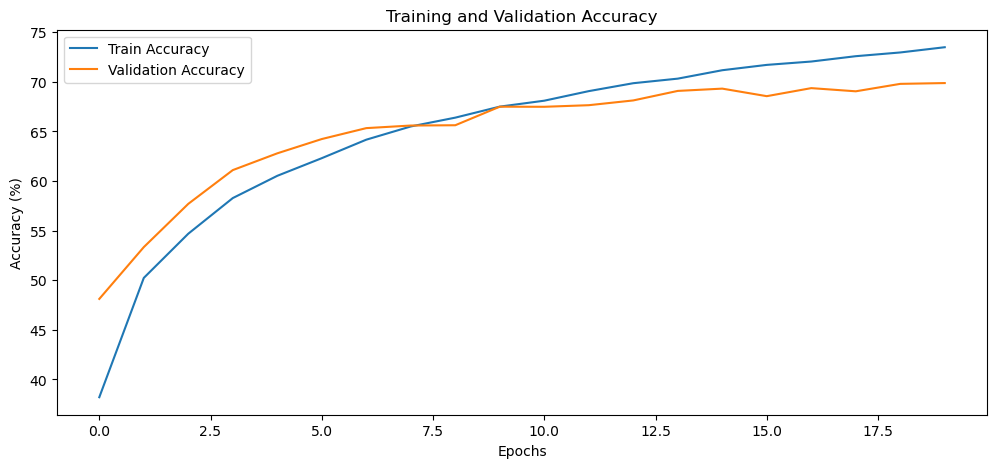

In [29]:
plt.figure(figsize=(12, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Per Class accuracy:

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [31]:
class_total = [0.] * 10 # list to store the total number of images for each class
class_correct = [0.] * 10 # list to store the number of correct predictions for each class

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        c = (predicted == labels).squeeze()
        
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("\n--- Per-Class Accuracy ---")
for i in range(10):
    if class_total[i] > 0:
        print(f'Accuracy of {classes[i]:<10s}: {100 * class_correct[i] / class_total[i]:.2f} %')
    else:
        print(f'Accuracy of {classes[i]:<10s}: N/A (no samples)')



--- Per-Class Accuracy ---
Accuracy of plane     : 74.10 %
Accuracy of car       : 78.90 %
Accuracy of bird      : 58.40 %
Accuracy of cat       : 53.60 %
Accuracy of deer      : 69.60 %
Accuracy of dog       : 58.20 %
Accuracy of frog      : 74.90 %
Accuracy of horse     : 76.00 %
Accuracy of ship      : 75.60 %
Accuracy of truck     : 79.40 %
